# Peaks
Illustrates how to find peaks in histograms.

This script generates a random number of gaussian peaks
on top of a linear background.
The position of the peaks is found via TSpectrum and injected
as initial values of parameters to make a global fit.
The background is computed and drawn on top of the original histogram.

This script can fit "peaks' heights" or "peaks' areas" (comment out
or uncomment the line which defines `__PEAKS_C_FIT_AREAS__`).

To execute this example, do (in ROOT 5 or ROOT 6):

```cpp
 root > .x peaks.C  (generate 10 peaks by default)
 root > .x peaks.C++ (use the compiler)
 root > .x peaks.C++(30) (generates 30 peaks)
```

To execute only the first part of the script (without fitting)
specify a negative value for the number of peaks, eg

```cpp
 root > .x peaks.C(-20)
```




**Author:** Rene Brun  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Thursday, August 29, 2019 at 03:37 AM.</small></i>

In [1]:
%%cpp -d
#include "TCanvas.h"
#include "TMath.h"
#include "TH1.h"
#include "TF1.h"
#include "TRandom.h"
#include "TSpectrum.h"
#include "TVirtualFitter.h"

 Comment out the line below, if you want "peaks' heights".
 Uncomment the line below, if you want "peaks' areas".

 #define __PEAKS_C_FIT_AREAS__ 1 /* fit peaks' areas */

In [2]:
Int_t npeaks = 30;

 A helper function is created: 

In [3]:
%%cpp -d
Double_t fpeaks(Double_t *x, Double_t *par) {
   Double_t result = par[0] + par[1]*x[0];
   for (Int_t p=0;p<npeaks;p++) {
      Double_t norm  = par[3*p+2]; // "height" or "area"
      Double_t mean  = par[3*p+3];
      Double_t sigma = par[3*p+4];
#if defined(__PEAKS_C_FIT_AREAS__)
      norm /= sigma * (TMath::Sqrt(TMath::TwoPi())); // "area"
#endif /* defined(__PEAKS_C_FIT_AREAS__) */
      result += norm*TMath::Gaus(x[0],mean,sigma);
   }
   return result;
}

 Arguments are defined. 

In [4]:
Int_t np=10;

In [5]:
npeaks = TMath::Abs(np);
TH1F *h = new TH1F("h","test",500,0,1000);

Generate n peaks at random

In [6]:
Double_t par[3000];
par[0] = 0.8;
par[1] = -0.6/1000;
Int_t p;
for (p=0;p<npeaks;p++) {
   par[3*p+2] = 1; // "height"
   par[3*p+3] = 10+gRandom->Rndm()*980; // "mean"
   par[3*p+4] = 3+2*gRandom->Rndm(); // "sigma"
#if defined(__PEAKS_C_FIT_AREAS__)
   par[3*p+2] *= par[3*p+4] * (TMath::Sqrt(TMath::TwoPi())); // "area"
#endif /* defined(__PEAKS_C_FIT_AREAS__) */
}
TF1 *f = new TF1("f",fpeaks,0,1000,2+3*npeaks);
f->SetNpx(1000);
f->SetParameters(par);
TCanvas *c1 = new TCanvas("c1","c1",10,10,1000,900);
c1->Divide(1,2);
c1->cd(1);
h->FillRandom("f",200000);
h->Draw();
TH1F *h2 = (TH1F*)h->Clone("h2");

Use tspectrum to find the peak candidates

In [7]:
TSpectrum *s = new TSpectrum(2*npeaks);
Int_t nfound = s->Search(h,2,"",0.10);
printf("Found %d candidate peaks to fit\n",nfound);

Found 9 candidate peaks to fit


Estimate background using tspectrum::background

In [8]:
TH1 *hb = s->Background(h,20,"same");
if (hb) c1->Update();
if (np <0) return;

Estimate linear background using a fitting method

In [9]:
c1->cd(2);
TF1 *fline = new TF1("fline","pol1",0,1000);
h->Fit("fline","qn");

Loop on all found peaks. eliminate peaks at the background level

In [10]:
par[0] = fline->GetParameter(0);
par[1] = fline->GetParameter(1);
npeaks = 0;
Double_t *xpeaks;
xpeaks = s->GetPositionX();
for (p=0;p<nfound;p++) {
   Double_t xp = xpeaks[p];
   Int_t bin = h->GetXaxis()->FindBin(xp);
   Double_t yp = h->GetBinContent(bin);
   if (yp-TMath::Sqrt(yp) < fline->Eval(xp)) continue;
   par[3*npeaks+2] = yp; // "height"
   par[3*npeaks+3] = xp; // "mean"
   par[3*npeaks+4] = 3; // "sigma"
#if defined(__PEAKS_C_FIT_AREAS__)
   par[3*npeaks+2] *= par[3*npeaks+4] * (TMath::Sqrt(TMath::TwoPi())); // "area"
#endif /* defined(__PEAKS_C_FIT_AREAS__) */
   npeaks++;
}
printf("Found %d useful peaks to fit\n",npeaks);
printf("Now fitting: Be patient\n");
TF1 *fit = new TF1("fit",fpeaks,0,1000,2+3*npeaks);

Found 9 useful peaks to fit
Now fitting: Be patient


We may have more than the default 25 parameters

In [11]:
TVirtualFitter::Fitter(h2,10+3*npeaks);
fit->SetParameters(par);
fit->SetNpx(1000);
h2->Fit("fit");

 FCN=596.686 FROM MIGRAD    STATUS=CONVERGED    1343 CALLS        1344 TOTAL
                     EDM=3.92392e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   4.1 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.27684e+02   2.01895e+00   1.61337e-04   1.75611e-05
   2  p1          -3.95030e-01   3.04733e-03  -2.24976e-07   9.00273e-03
   3  p2           6.34691e+02   2.03922e+01   6.11343e-03   8.34700e-06
   4  p3           5.19331e+02   9.71873e-02  -3.36434e-05   5.32034e-03
   5  p4           3.49850e+00   1.08256e-01  -2.36209e-05   1.49297e-03
   6  p5           6.64734e+02   1.64194e+01  -1.21344e-03   3.63148e-06
   7  p6           3.19147e+02   1.05478e-01   7.08426e-06   2.00939e-04
   8  p7           4.69148e+00   9.07160e-02   1.69389e-06  -1.62399e-03
   9  p8           6.70930e+02   1.64206e+01   3.50063e-03  -9.49091e-06
  10  p9           7.54806e+0

Draw all canvases 

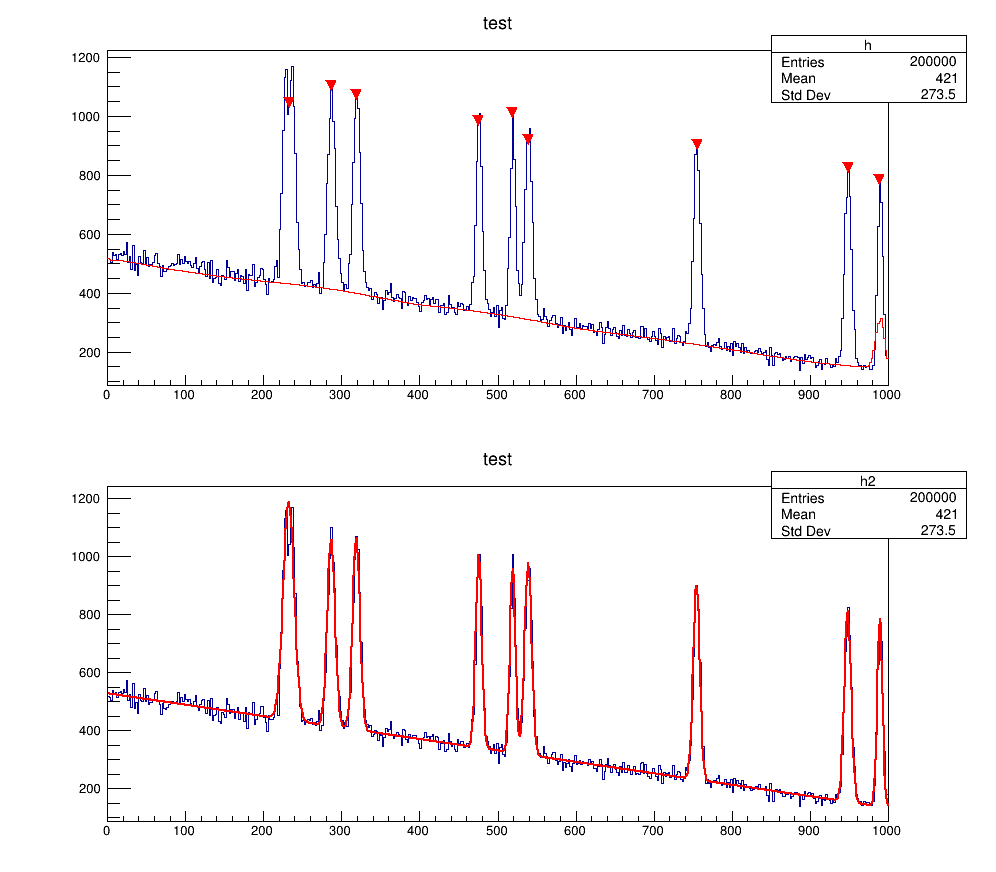

In [12]:
gROOT->GetListOfCanvases()->Draw()